In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

In [2]:
Dir = r"C:\Users\60112\Desktop\Semester 2\ML\Project\ML Project(1)\Face Mask Detection" 
Classes = ["with_mask", "without_mask"]
data, labels = [], []
imageObjects = []

for category in Classes:
    path = os.path.join(Dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        labels.append(category)
        imageObjects.append(image) 
        data.append(image)

C:\Users\60112\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

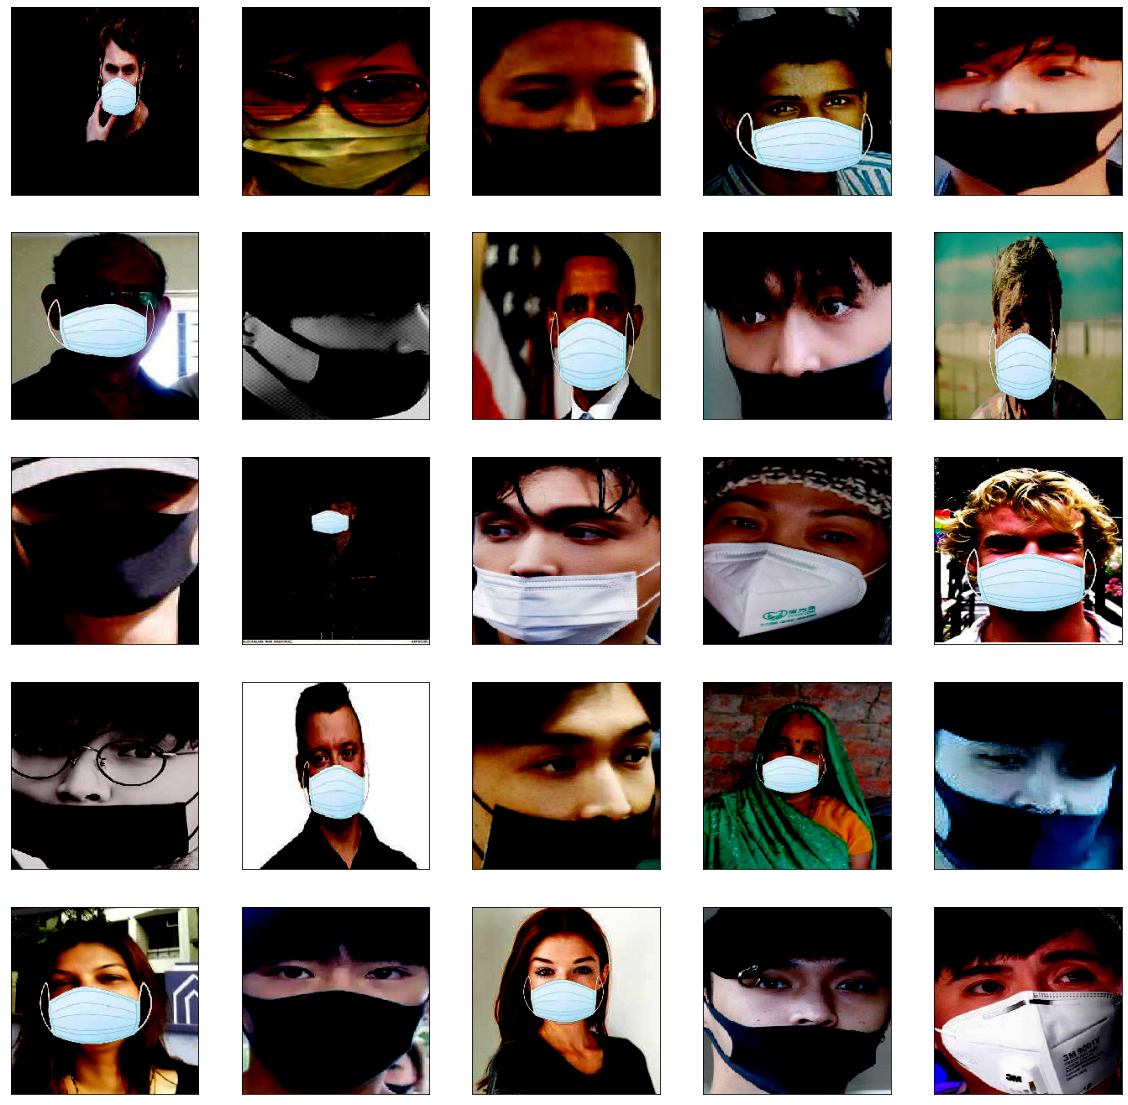

In [3]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imageObjects[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

In [4]:
LB = LabelBinarizer()
labels = LB.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
print(labels[:1])
print(labels[4000:4001])


[[1. 0.]]
[[0. 1.]]


In [7]:
print(len(labels))
print(len(data))

7553
7553


In [8]:
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size = 0.30,
                                                     stratify=labels, random_state=50)

In [9]:
data_aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    fill_mode = "nearest"
)

In [10]:
#MobileNetV2 network
base_model = MobileNetV2(weights="imagenet", include_top=False,
                         input_tensor=Input(shape=(224, 224, 3)))

#Head of the model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

#Form the actual model (connect head and base)
model = Model(inputs = base_model.input, 
              outputs = head_model)

#Loop over every layer in the base model and freeze it so that
# it will NOT be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

learning_rate = 1e-4
batches = 32
epo = 20

opt = Adam(lr=learning_rate, decay=learning_rate / epo)
model.compile(loss = "binary_crossentropy",
             optimizer = opt, metrics = ["accuracy"])

#Train head
head = model.fit(
    data_aug.flow(train_x, train_y, batch_size = batches),
    steps_per_epoch = len(train_x) // batches,
    validation_data = (test_x, test_y),
    validation_steps = len(test_x) // batches,
    epochs = epo
)

Epoch 1/20
165/165 [==============================] - 167s 996ms/step - loss: 0.4870 - accuracy: 0.8013 - val_loss: 0.1130 - val_accuracy: 0.9718
Epoch 2/20
165/165 [==============================] - 112s 675ms/step - loss: 0.1276 - accuracy: 0.9674
Epoch 3/20
165/165 [==============================] - 108s 655ms/step - loss: 0.0787 - accuracy: 0.9806
Epoch 4/20
165/165 [==============================] - 108s 652ms/step - loss: 0.0658 - accuracy: 0.9812
Epoch 5/20
165/165 [==============================] - 108s 654ms/step - loss: 0.0620 - accuracy: 0.9795
Epoch 6/20
165/165 [==============================] - 107s 646ms/step - loss: 0.0558 - accuracy: 0.9844
Epoch 7/20
165/165 [==============================] - 106s 642ms/step - loss: 0.0467 - accuracy: 0.9852
Epoch 8/20
165/165 [==============================] - 107s 644ms/step - loss: 0.0472 - accuracy: 0.9856
Epoch 9/20
165/165 [==============================] - 107s 644ms/step - loss: 0.0423 - accuracy: 0.9874
Epoch 10/20
165/165 [=

In [11]:
#Make predictions
pred = model.predict(test_x, batch_size=batches)

In [12]:
#For each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
pred = np.argmax(pred, axis=1)

In [13]:
# show a classification report
print(classification_report(test_y.argmax(axis=1), pred,
                            target_names=LB.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99      1118
without_mask       0.99      0.99      0.99      1148

    accuracy                           0.99      2266
   macro avg       0.99      0.99      0.99      2266
weighted avg       0.99      0.99      0.99      2266



In [ ]:
model.save("face_mask_classifier.model", save_format="h5")

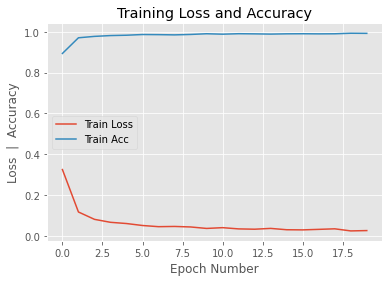

In [14]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epo), head.history["loss"], label="Train Loss")
plt.plot(np.arange(0, epo), head.history["accuracy"], label="Train Acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Loss  |  Accuracy")
plt.legend(loc="center left")
# plt.savefig("face_mask_plot.png")